## Place Recognition

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pygsp import graphs, filters, plotting, reduction
import pandas

%load_ext autoreload
%autoreload 2
%matplotlib inline

plotting.BACKEND = 'matplotlib'
plt.rcParams['figure.figsize'] = (10, 5)

#COLOR = 'white'
#plt.rcParams['text.color'] = COLOR
#plt.rcParams['axes.labelcolor'] = COLOR
#plt.rcParams['xtick.color'] = COLOR
#plt.rcParams['ytick.color'] = COLOR


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
dataset_path = '/home/berlukas/Documents/workspace/fgsp_ws/src/fgsp/data/gonzen_combined/'
opt_mission_01_file = dataset_path + 'mission_01.csv'
opt_mission_02_file = dataset_path + 'mission_02.csv'
opt_mission_03_file = dataset_path + 'mission_03.csv'
opt_mission_04_file = dataset_path + 'mission_04.csv'

labels = ['ts', 'vertex-id', 'mission_id', 'p_G_Ix', 'p_G_Iy', 'p_G_Iz', 'q_G_Iw', 'q_G_Ix', 'q_G_Iy', 'q_G_Iz', 'p_M_Ix', 'p_M_Iy', 'p_M_Iz', 'q_M_Iw', 'q_M_Ix', 'q_M_Iy', 'q_M_Iz', 'v_Mx', 'v_My', 'v_Mz', 'bgx', 'bgy', 'bgz', 'bax', 'bay', 'baz']
opt_mission_01_df = pandas.read_csv(opt_mission_01_file, names=labels, delimiter=',', header=None)
opt_mission_02_df = pandas.read_csv(opt_mission_02_file, names=labels, delimiter=',', header=None)
opt_mission_03_df = pandas.read_csv(opt_mission_03_file, names=labels, delimiter=',', header=None)
opt_mission_04_df = pandas.read_csv(opt_mission_04_file, names=labels, delimiter=',', header=None)

print(f'\nRead from mission 01: {opt_mission_01_df.size} (optimized)  entries.')
print(f'\nRead from mission 02: {opt_mission_02_df.size} (optimized)  entries.')
print(f'\nRead from mission 03: {opt_mission_03_df.size} (optimized)  entries.')
print(f'\nRead from mission 04: {opt_mission_04_df.size} (optimized)  entries.')


Read from mission 01: 64064 (optimized)  entries.

Read from mission 02: 58214 (optimized)  entries.

Read from mission 03: 28990 (optimized)  entries.

Read from mission 04: 51870 (optimized)  entries.


In [51]:
opt_mission_01_graph = opt_mission_01_df[['p_G_Ix', 'p_G_Iy', 'p_G_Iz']].to_numpy()
opt_mission_02_graph = opt_mission_02_df[['p_G_Ix', 'p_G_Iy', 'p_G_Iz']].to_numpy()
opt_mission_03_graph = opt_mission_03_df[['p_G_Ix', 'p_G_Iy', 'p_G_Iz']].to_numpy()
opt_mission_04_graph = opt_mission_04_df[['p_G_Ix', 'p_G_Iy', 'p_G_Iz']].to_numpy()

G_mission_01 = graphs.NNGraph(opt_mission_01_graph, use_flann=False, k=3)
G_mission_01.compute_fourier_basis()

G_mission_02 = graphs.NNGraph(opt_mission_02_graph, use_flann=False, k=3)
G_mission_02.compute_fourier_basis()

G_mission_03 = graphs.NNGraph(opt_mission_03_graph, use_flann=False, k=3)
G_mission_03.compute_fourier_basis()

G_mission_04 = graphs.NNGraph(opt_mission_04_graph, use_flann=False, k=3)
G_mission_04.compute_fourier_basis()

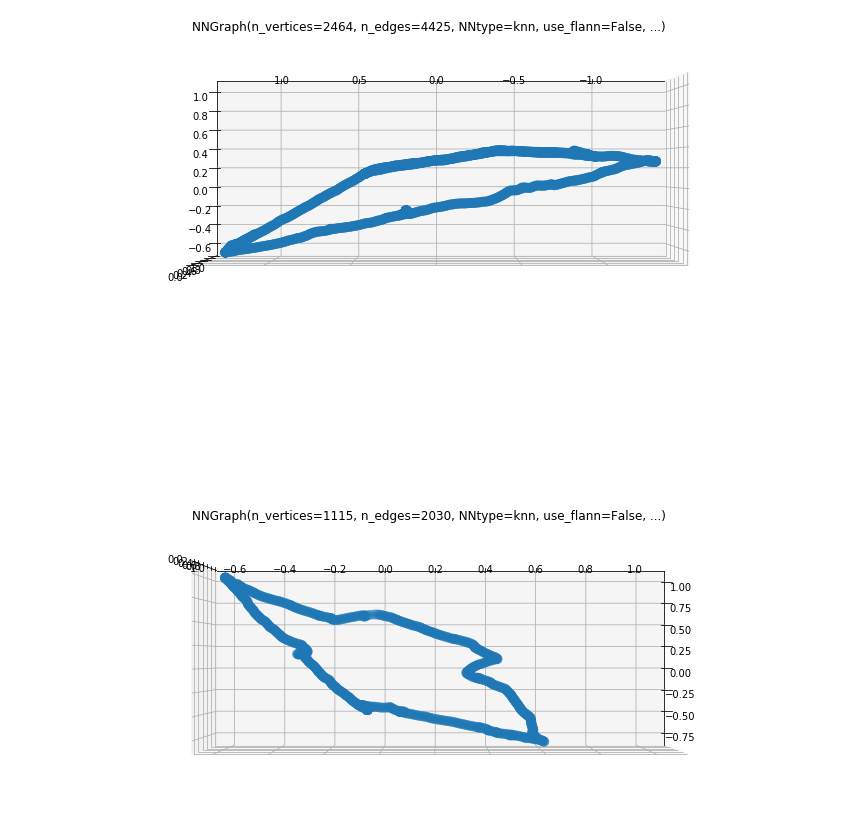

In [46]:

fig, axes = plt.subplots(2, 1, figsize=(15, 15), subplot_kw={'projection': '3d'})
fig.subplots_adjust(hspace=0.5)
G_mission_01.plot(ax=axes[0])
G_mission_03.plot(ax=axes[1])

axes[0].view_init(azim=90, elev=-90)
axes[1].view_init(azim=0, elev=-90)